In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.metrics import classification_report, confusion_matrix
from scipy import stats
from mlxtend.frequent_patterns import apriori, association_rules

# Cấu hình hiển thị
%matplotlib inline
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

In [3]:
df= pd.read_csv("../data/processed/bank_marketing_raw.csv")
df

,age,job,marital,education,default,balance,housing,loan,contact,day_of_week,...,duration,campaign,pdays,previous,poutcome,y,poutcome_missing,target,pdays_contacted,has_previous_campaign
0,58,management,married,tertiary,no,2143,yes,no,NaN,5,...,261,1,-1,0,no_previous_campaign,no,1,0,1,0
1,44,technician,single,secondary,no,29,yes,no,NaN,5,...,151,1,-1,0,no_previous_campaign,no,1,0,1,0
2,33,entrepreneur,married,secondary,no,2,yes,yes,NaN,5,...,76,1,-1,0,no_previous_campaign,no,1,0,1,0
3,47,blue-collar,married,NaN,no,1506,yes,no,NaN,5,...,92,1,-1,0,no_previous_campaign,no,1,0,1,0
4,33,NaN,single,NaN,no,1,no,no,NaN,5,...,198,1,-1,0,no_previous_campaign,no,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,technician,married,tertiary,no,825,no,no,cellular,17,...,977,3,-1,0,no_previous_campaign,yes,1,1,1,0
45207,71,retired,divorced,primary,no,1729,no,no,cellular,17,...,456,2,-1,0,no_previous_campaign,yes,1,1,1,0
45208,72,retired,married,secondary,no,5715,no,no,cellular,17,...,1127,5,184,3,success,yes,0,1,1,1
45209,57,blue-collar,married,secondary,no,668,no,no,telephone,17,...,508,4,-1,0,no_previous_campaign,no,1,0,1,0


# Tri thức: giới hạn số lần gọi/khách.

In [4]:
# Fatigue curve: gọi bao nhiêu lần thì hiệu quả bắt đầu giảm?
le=LabelEncoder()
df['y_encode']= le.fit_transform(df['y'])

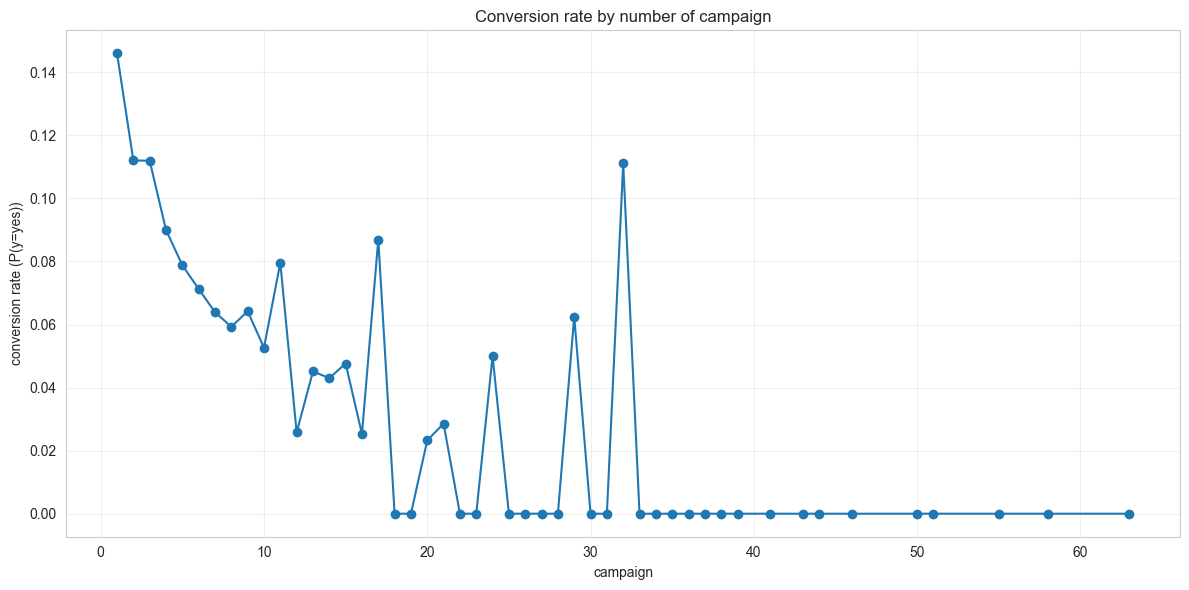

In [5]:
# Tìm “điểm dừng”: từ lần gọi thứ k, lift giảm mạnh
rate_by_campaign = df.groupby("campaign")["y_encode"].mean().sort_index()

# 4) Vẽ biểu đồ
plt.figure(figsize=(12, 6))
plt.plot(rate_by_campaign.index, rate_by_campaign.values, marker="o")
plt.xlabel("campaign")
plt.ylabel("conversion rate (P(y=yes))")
plt.title("Conversion rate by number of campaign")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

**Điểm dừng tối ưu**: Campaign = 3 hoặc 4. Vì sau lần gọi này Conversion giảm mạnh, lợi ích biên thấp. Ngân sách nên chuyển sang khách hàng khác, thay vì gọi lại nhiều lần.


In [6]:
# Tối ưu chiến dịch kết hợp với pdays, poutcome, contact
df["contacted_before"] = (df["pdays"] != 999).astype(int)

In [7]:
df["history_group"] = "new"

df.loc[df["poutcome"] == "success", "history_group"] = "prev_success"
df.loc[df["poutcome"] == "failure", "history_group"] = "prev_failure"

In [8]:
# Hiệu quả từng nhóm
policy_stats = (
    df[df["campaign"] <= 3]
    .groupby(["history_group", "contact"])["y_encode"]
    .agg(["mean", "count"])
    .reset_index()
    .sort_values("mean", ascending=False)
)

print(policy_stats)

  history_group    contact      mean  count
5  prev_success  telephone  0.690000    100
4  prev_success   cellular  0.664577   1276
3  prev_failure  telephone  0.141264    269
0           new   cellular  0.136542  17826
1           new  telephone  0.132191   1634
2  prev_failure   cellular  0.131696   4032


Nếu đã thành công ở chiến dịch trước thì conversion ~66–69% ở chiến dịch này, cao gấp ~5 lần so với khách hàng mới (~13%). Contact channel gần như không quan trọng nếu khách từng đồng ý trước đó. Với khách hàng mới hoặc khách đã từ chối chiến dịch trước thì thay đổi contact channel không đem lại tác động tích cực.

---
## Luật hành động
IF campaign > 3
    → STOP

ELSE IF history_group = "prev_success"
    → CALL (ưu tiên cao, mọi kênh đều hiệu quả)

ELSE IF history_group = "prev_failure"
    → LOW PRIORITY (chỉ gọi nếu còn ngân sách)

ELSE IF history_group = "new"
    → CALL (ưu tiên thấp, conversion ~13%)

ELSE
    → STOP

---

# Tri thức để tối ưu lịch và kênh gọi.

In [9]:
# Khi nào/kênh nào hiệu quả hơn?

In [10]:
# Conversion theo contact (cellular/telephone/unknown)
contact_stats = (
    df.groupby("contact")["y_encode"]
      .agg(mean="mean", count="count")
      .reset_index()
      .sort_values("mean", ascending=False)
)

print(contact_stats)


     contact      mean  count
0   cellular  0.149189  29285
1  telephone  0.134205   2906


In [11]:
# Conversion theo tháng
month_stats = (
    df.groupby("month")["y_encode"]
      .agg(mean="mean", count="count")
      .reset_index()
    #   .sort_values("mean", ascending=False)
)

print(month_stats)


   month      mean  count
0    apr  0.196794   2932
1    aug  0.110133   6247
2    dec  0.467290    214
3    feb  0.166478   2649
4    jan  0.101212   1403
5    jul  0.090935   6895
6    jun  0.102228   5341
7    mar  0.519916    477
8    may  0.067195  13766
9    nov  0.101511   3970
10   oct  0.437669    738
11   sep  0.464594    579


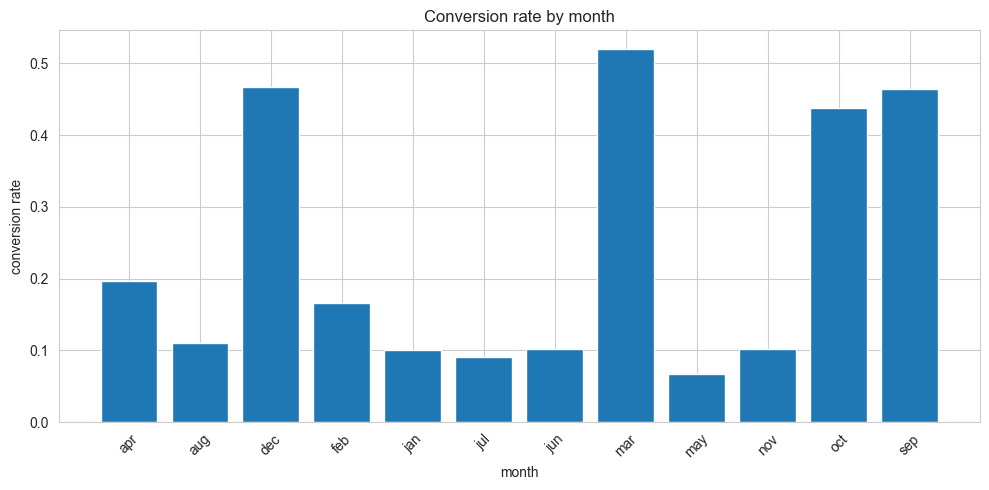

In [12]:
plt.figure(figsize=(10, 5))
plt.bar(month_stats["month"], month_stats["mean"])
plt.xlabel("month")
plt.ylabel("conversion rate")
plt.title("Conversion rate by month")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [13]:
combo_stats = (
    df.groupby(["month", "contact"])["y_encode"]
      .agg(mean="mean", count="count")
      .reset_index()
      .sort_values("mean", ascending=False)
)

print(combo_stats.head(15))


   month    contact      mean  count
14   mar   cellular  0.532374    417
22   sep   cellular  0.517167    466
4    dec   cellular  0.494253    174
20   oct   cellular  0.447038    557
12   jun   cellular  0.438957    729
21   oct  telephone  0.435115    131
15   mar  telephone  0.415094     53
23   sep  telephone  0.378788     66
5    dec  telephone  0.378378     37
13   jun  telephone  0.250000     80
1    apr  telephone  0.195980    199
0    apr   cellular  0.195453   2727
6    feb   cellular  0.168925   2362
7    feb  telephone  0.138686    274
3    aug  telephone  0.130081    246


Cellular > Telephone trong mọi tháng. Có các tháng có conversion rate RẤT TỐT như
- March (~53%)
- September (~52%)
- October (~45%)
- June (~44%)

Cellular + {Mar, Sep, Oct, Jun} = hiệu quả vượt trội

---
## Rule
IF contact = cellular AND month ∈ {March, September, October, June}
    → HIGH PRIORITY CALL

IF contact = cellular AND month ∈ {April, February}
    → MEDIUM PRIORITY

IF contact = telephone
    → LOW PRIORITY

IF contact = unknown
    → DO NOT CALL
    
---

# Association Rules: Apriori

In [14]:
# BIN campaign
df["campaign_bin"] = pd.cut(
    df["campaign"],
    bins=[0, 2, 4, 100],
    labels=["camp_le_2", "camp_3_4", "camp_gt_4"]
)

# Giữ các cột cần thiết
df_rules = df[[
    "poutcome",
    "campaign_bin",
    "contact",
    "y"
]]

In [15]:
df_ohe = pd.get_dummies(df_rules)

In [16]:

# 1) Frequent itemsets
freq_items = apriori(
    df_ohe,
    min_support=0.01,   # ≥ 1%
    use_colnames=True
)

# 2) Association rules
rules = association_rules(
    freq_items,
    metric="confidence",
    min_threshold=0.6   # ≥ 60%
)


In [17]:
rules_yes = rules[
    rules["consequents"].astype(str).str.contains("y_yes")
].copy()

rules_yes = rules_yes.sort_values(
    by=["lift", "confidence"],
    ascending=False
)

rules_yes[[
    "antecedents",
    "support",
    "confidence",
    "lift"
]].head(10)


,antecedents,support,confidence,lift
145,"(poutcome_success, campaign_bin_camp_le_2)",0.016655,0.607748,6.289060
142,"(contact_cellular, poutcome_success, campaign_...",0.016655,0.659947,5.641309
83,"(poutcome_success, campaign_bin_camp_le_2)",0.018027,0.657789,5.622855
85,"(contact_cellular, poutcome_success)",0.019907,0.649819,5.554734
17,(poutcome_success),0.021632,0.647253,5.532800


Luật tốt nhất là poutcome_success AND campaign ≤ 2 → y = yes

Mức độ ưu tiên
1. poutcome=success AND campaign≤2 → CALL (PRIORITY 1)
2. poutcome=success → CALL (PRIORITY 2)
33.  else → áp dụng rule fatigue (campaign≤3) + kênh + tháng